# Job Data Cleaning and Preprocessing

## Overview
This notebook performs **data cleaning and preprocessing** for job postings.  
The dataset is sourced from Kaggle and contains over **120,000 job postings**.

### **Objectives**
- Load raw job postings data from `/data/raw_data.csv`
- Explore the dataset and understand its structure
- Identify missing values and inconsistent data
- Prepare the dataset for use in a FastAPI job search API

### **Dataset Information**
The dataset contains **job postings** with the following attributes:
- **job_id** – Unique identifier for each job  
- **company_name** – Name of the hiring company  
- **title** – Job title  
- **description** – Job description text  
- **max_salary, min_salary, med_salary** – Salary estimates  
- **pay_period** – Whether salary is hourly, monthly, etc.  
- **location** – Job location  
- **remote_allowed** – Whether the job allows remote work  
- **skills_desc** – Required skills  
- **listed_time** – Date when the job was listed  

## Load Raw Data
Now, let's load the dataset into a Pandas DataFrame.

In [87]:
# 📌 Import necessary libraries
import pandas as pd  # For handling data
import numpy as np   # For numerical operations
import seaborn as sns  # For visualization
import matplotlib.pyplot as plt  # For plotting

# 📂 Load the dataset
df = pd.read_csv("../data/raw_jobs_data.csv")

# 🏷️ Display the first 5 rows
df.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


## Check Dataset Information
Before proceeding, let's check dataset size and column types.

In [88]:
# Check dataset size
print(f"Dataset contains {df.shape[0]:,} rows and {df.shape[1]} columns.")

# Check column data types and missing values
df.info()

Dataset contains 123,849 rows and 31 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  int64  
 1   company_name                122130 non-null  object 
 2   title                       123849 non-null  object 
 3   description                 123842 non-null  object 
 4   max_salary                  29793 non-null   float64
 5   pay_period                  36073 non-null   object 
 6   location                    123849 non-null  object 
 7   company_id                  122132 non-null  float64
 8   views                       122160 non-null  float64
 9   med_salary                  6280 non-null    float64
 10  min_salary                  29793 non-null   float64
 11  formatted_work_type         123849 non-null  object 
 12  applies                   

## Check for Missing Values
We need to identify columns with missing values and determine how to handle them.

In [89]:
# Check for missing values
missing_values = df.isnull().sum()

# Display only columns with missing values
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(ascending=False)

closed_time                   122776
skills_desc                   121410
med_salary                    117569
remote_allowed                108603
applies                       100529
min_salary                     94056
max_salary                     94056
pay_period                     87776
compensation_type              87776
normalized_salary              87776
currency                       87776
posting_domain                 39968
application_url                36665
formatted_experience_level     29409
fips                           27415
zip_code                       20872
company_name                    1719
company_id                      1717
views                           1689
description                        7
dtype: int64

## Understanding Missing Values
From the above analysis:

- Columns with a high percentage of missing values (e.g., 50%+) → Consider dropping them.
- Columns with a few missing values → Consider filling them with default values.

## Visualizing Missing Data
To better understand where the missing values are, let's use a heatmap.

<Figure size 1200x600 with 0 Axes>

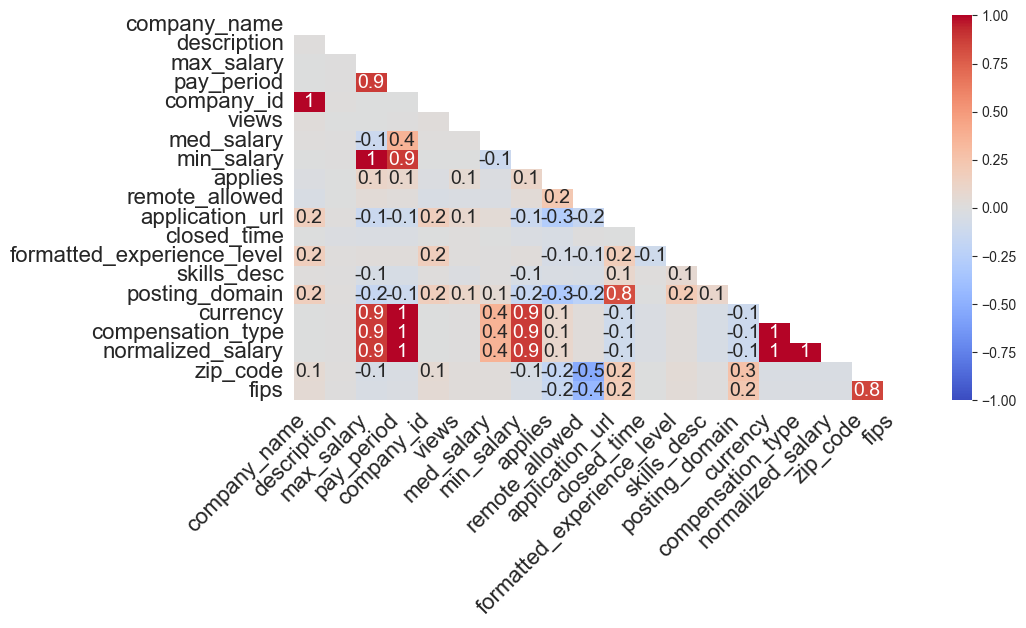

In [90]:
import missingno as msno  # Library for visualizing missing values

## Plot missing values as a heatmap
plt.figure(figsize=(12, 6))
msno.heatmap(df, cmap="coolwarm", figsize=(10,5))
plt.show()

## Handling Missing Values

Now that we have loaded and explored the dataset, we need to address any missing values. Handling missing data properly ensures that our model does not encounter errors or biases due to incomplete information.

We will use different strategies depending on the column:

| Column | Missing Data Handling Strategy |
| --- | --- |
| `max_salary`, `min_salary`, `med_salary` | Fill missing values with the median salary of the dataset |
| `skills_desc` | Fill missing values with `"Unknown"` to indicate missing skills information |
| `remote_allowed` | Fill missing values with the **mode (most common value)** |
| `company_name`, `title`, `location` | Drop rows if missing, as these fields are essential for job postings |
| `description` | Fill missing values with `"No description available"` |

### Why These Strategies?
- **Median for salary columns**: The median is less sensitive to extreme values compared to the mean, making it a better choice for handling salary data.
- **Mode for categorical values (e.g., remote_allowed)**: This ensures that we assign the most frequent category to missing values.
- **Filling descriptions with a default text**: Helps maintain consistency and avoids completely removing job posts with missing descriptions.
- **Dropping rows with missing company_name, title, or location**: These are critical for job postings, and a missing value here likely means incomplete data.

Next, we will apply these transformations programmatically to clean the dataset.

## Checking for missing values
Check missing values for every column.

In [91]:
print("Missing values before cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
job_id                             0
company_name                    1719
title                              0
description                        7
max_salary                     94056
pay_period                     87776
location                           0
company_id                      1717
views                           1689
med_salary                    117569
min_salary                     94056
formatted_work_type                0
applies                       100529
original_listed_time               0
remote_allowed                108603
job_posting_url                    0
application_url                36665
application_type                   0
expiry                             0
closed_time                   122776
formatted_experience_level     29409
skills_desc                   121410
listed_time                        0
posting_domain                 39968
sponsored                          0
work_type                          0
curren

## Cleaning Missing values
Handle missing values for each column.

In [92]:
# Handle missing values for each column
# 1. pay_period: Fill with "Unknown" (categorical column)
df['pay_period'] = df['pay_period'].fillna("Unknown")

# 2. views: Fill with median (numeric column)
df['views'] = df['views'].fillna(df['views'].median())

# 3. applies: Fill with 0 (assuming missing means no applies)
df['applies'] = df['applies'].fillna(0)

# 4. application_url: Fill with "Not Provided" (URL column)
df['application_url'] = df['application_url'].fillna("Not Provided")

# 5. closed_time: Fill with a default date (datetime column)
df['closed_time'] = df['closed_time'].fillna(pd.Timestamp('1970-01-01'))

# 6. posting_domain: Fill with "Unknown" (categorical column)
df['posting_domain'] = df['posting_domain'].fillna("Unknown")

# 7. compensation_type: Fill with "Unknown" (categorical column)
df['compensation_type'] = df['compensation_type'].fillna("Unknown")

# 8. zip_code: Fill with "Unknown" (categorical column, as zip codes are not numeric)
df['zip_code'] = df['zip_code'].fillna("Unknown")

# 9. fips: Fill with 0 (numeric column, assuming missing means no FIPS code)
df['fips'] = df['fips'].fillna(0)

# 10. currency: Fill with "Unknown" (categorical column)
df['currency'] = df['currency'].fillna("Unknown")

# 11. normalized_salary: Fill with median (numeric column)
df['normalized_salary'] = df['normalized_salary'].fillna(df['normalized_salary'].median())

# 12. remote_allowed: Fill with False (boolean column)
df['remote_allowed'] = df['remote_allowed'].fillna(False)

# 13. formatted_experience_level: Fill with "Unknown" (categorical column)
df['formatted_experience_level'] = df['formatted_experience_level'].fillna("Unknown")

# 14. skills_desc: Fill with "No Skills Description" (categorical column)
df['skills_desc'] = df['skills_desc'].fillna("No Skills Description")

# 15. company_name: Fill with "Unknown" (categorical column)
df['company_name'] = df['company_name'].fillna("Unknown")

# 16. description: Fill with "No Description" (categorical column)
df['description'] = df['description'].fillna("No Description")

# 17. max_salary: Fill with median (numeric column)
df['max_salary'] = df['max_salary'].fillna(df['max_salary'].median())

# 18. company_id: Fill with 0 (assuming missing means no company ID)
df['company_id'] = df['company_id'].fillna(0)

# 19. med_salary: Fill with median (numeric column)
df['med_salary'] = df['med_salary'].fillna(df['med_salary'].median())

# 20. min_salary: Fill with median (numeric column)
df['min_salary'] = df['min_salary'].fillna(df['min_salary'].median())

# Verify missing values after cleaning
print("\nMissing values after cleaning:")
print(df.isnull().sum())


Missing values after cleaning:
job_id                        0
company_name                  0
title                         0
description                   0
max_salary                    0
pay_period                    0
location                      0
company_id                    0
views                         0
med_salary                    0
min_salary                    0
formatted_work_type           0
applies                       0
original_listed_time          0
remote_allowed                0
job_posting_url               0
application_url               0
application_type              0
expiry                        0
closed_time                   0
formatted_experience_level    0
skills_desc                   0
listed_time                   0
posting_domain                0
sponsored                     0
work_type                     0
currency                      0
compensation_type             0
normalized_salary             0
zip_code                      0
fips    

## Remove Duplicates
We need to check if there are duplicate job postings and remove them.

In [93]:
# Check for duplicate job postings
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 0


## Selecting Relevant Columns
Since we only need certain columns, we will drop the unnecessary ones and keep only the required ones.

In [94]:
# Define the columns to keep
columns_to_keep = [
    "company_name", "title", "description", "min_salary", "med_salary", "max_salary", 
    "pay_period", "location", "views", "original_listed_time", "remote_allowed", 
    "application_type", "expiry", "formatted_experience_level", "skills_desc", 
    "sponsored", "work_type", "currency"
]

# Keep only the selected columns
df = df[columns_to_keep]

# Verify the new dataframe structure
df.head()

,company_name,title,description,min_salary,med_salary,max_salary,pay_period,location,views,original_listed_time,remote_allowed,application_type,expiry,formatted_experience_level,skills_desc,sponsored,work_type,currency
0,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,17.0,25.5,20.0,HOURLY,"Princeton, NJ",20.0,1.713398e+12,False,ComplexOnsiteApply,1.715990e+12,Unknown,Requirements: \n\nWe are seeking a College or ...,0,FULL_TIME,USD
1,Unknown,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",30.0,25.5,50.0,HOURLY,"Fort Collins, CO",1.0,1.712858e+12,False,ComplexOnsiteApply,1.715450e+12,Unknown,No Skills Description,0,FULL_TIME,USD
2,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,45000.0,25.5,65000.0,YEARLY,"Cincinnati, OH",8.0,1.713278e+12,False,ComplexOnsiteApply,1.715870e+12,Unknown,We are currently accepting resumes for FOH - A...,0,FULL_TIME,USD
3,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,140000.0,25.5,175000.0,YEARLY,"New Hyde Park, NY",16.0,1.712896e+12,False,ComplexOnsiteApply,1.715488e+12,Unknown,This position requires a baseline understandin...,0,FULL_TIME,USD
4,Unknown,Service Technician,Looking for HVAC service tech with experience ...,60000.0,25.5,80000.0,YEARLY,"Burlington, IA",3.0,1.713452e+12,False,ComplexOnsiteApply,1.716044e+12,Unknown,No Skills Description,0,FULL_TIME,USD


## Renaming Some Columns
Now, let's rename the selected columns to make them more readable and easier to use in our FastAPI application.

In [95]:
# Define new column names
rename_columns = {
    "original_listed_time": "listed_time",
    "formatted_experience_level": "experience_level"
}

# Apply renaming
df.rename(columns=rename_columns, inplace=True)

# Verify the changes
df.head()

,company_name,title,description,min_salary,med_salary,max_salary,pay_period,location,views,listed_time,remote_allowed,application_type,expiry,experience_level,skills_desc,sponsored,work_type,currency
0,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,17.0,25.5,20.0,HOURLY,"Princeton, NJ",20.0,1.713398e+12,False,ComplexOnsiteApply,1.715990e+12,Unknown,Requirements: \n\nWe are seeking a College or ...,0,FULL_TIME,USD
1,Unknown,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",30.0,25.5,50.0,HOURLY,"Fort Collins, CO",1.0,1.712858e+12,False,ComplexOnsiteApply,1.715450e+12,Unknown,No Skills Description,0,FULL_TIME,USD
2,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,45000.0,25.5,65000.0,YEARLY,"Cincinnati, OH",8.0,1.713278e+12,False,ComplexOnsiteApply,1.715870e+12,Unknown,We are currently accepting resumes for FOH - A...,0,FULL_TIME,USD
3,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,140000.0,25.5,175000.0,YEARLY,"New Hyde Park, NY",16.0,1.712896e+12,False,ComplexOnsiteApply,1.715488e+12,Unknown,This position requires a baseline understandin...,0,FULL_TIME,USD
4,Unknown,Service Technician,Looking for HVAC service tech with experience ...,60000.0,25.5,80000.0,YEARLY,"Burlington, IA",3.0,1.713452e+12,False,ComplexOnsiteApply,1.716044e+12,Unknown,No Skills Description,0,FULL_TIME,USD


## Convert listed_time and expiry to Readable Datetime Format
- Convert the scientific notation (Unix timestamp) into a human-readable datetime format.
- Format it as ISO 8601 (YYYY-MM-DD HH:MM:SS), which is commonly used in APIs.

In [96]:
import pandas as pd

# Convert timestamp columns to datetime format
df["listed_time"] = pd.to_datetime(df["listed_time"], unit="ms")
df["expiry"] = pd.to_datetime(df["expiry"], unit="ms")

# Verify changes
df[["listed_time", "expiry"]].head()

,listed_time,expiry
0,2024-04-17 23:45:08,2024-05-17 23:45:08
1,2024-04-11 17:51:27,2024-05-11 17:51:27
2,2024-04-16 14:26:54,2024-05-16 14:26:54
3,2024-04-12 04:23:32,2024-05-12 04:23:32
4,2024-04-18 14:52:23,2024-05-18 14:52:23


## Save Cleaned Data
Save the cleaned dataset for use in our Job Application API.

In [97]:
df.to_csv("../data/cleaned_jobs_data.csv", index=False)